# DATA DOWNLOAD & ENVIRONMENT SETUP
These two lines of code below will install the necessary setup required to work with our Kaggle dataset, as well as create the necessary data directory for the project. The second code cell initiates the Spark session and imports os and the third code cell pulls from the Kaggle path and transfers the data into the data directory. Here is the link to the data: https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection?resource=download 

In [ ]:
!pip install --user kaggle
!mkdir -p data

In [2]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ImageSizeAnalysis").config("spark.driver.memory", "32g").config("spark.executor.memory", "32g").getOrCreate()

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('wanderdust/skin-lesion-analysis-toward-melanoma-detection', path='data', unzip=True)

The dataset I am working with involves image data, which are in .jpg format. The dataset has 2750 total images of skin lesions (as we can see from the output below) and the data came split into a training set, a testing set, and validation set.

In [3]:
img_df = (spark.read.format("image").option("recursiveFileLookup", "true").load("data"))
img_df.printSchema()
print(f"Total images: {img_df.count()}")

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)

Total images: 2750


Each set contains three classes: melanoma, nevus, and seborrheic keratosis. By modifying the path on the second line of code below, I obtained the following statistics from the nine possible paths. The training set has 374 images of melanoma, 1372 images of nevus, and 254 images of seborrheic keratosis, totaling out to 2000 images in the training set. The test set has 117 images of melanoma, 393 images of nevus, and 90 images of seborrheic keratosis, totaling out to 600 images in the test set. The validation set has 30 images of melanoma, 78 images of nevus, and 42 images of seborrheic keratosis, totaling out to 150 images in the validation set. Overall, it totals out to our aforementioned 2750 images.

In [3]:
images = [f for f in os.listdir('data/skin-lesions/valid/seborrheic_keratosis') if f.lower().endswith(('.jpg', '.png'))]
print(f"Found {len(images)} images:", images[:5])

Found 42 images: ['ISIC_0014712.jpg', 'ISIC_0012380.jpg', 'ISIC_0014568.jpg', 'ISIC_0013215.jpg', 'ISIC_0012492.jpg']


In [4]:
from pyspark.sql.functions import col
sizes_df = img_df.select(col("image.origin").alias("path"), col("image.height").cast("int").alias("height"), col("image.width").cast("int").alias("width"))
sizes_df.show(5, truncate = False)

+--------------------------------------------------------------------+------+-----+
|path                                                                |height|width|
+--------------------------------------------------------------------+------+-----+
|file:///home/dmolina1/data/skin-lesions/train/nevus/ISIC_0014923.jpg|4499  |6748 |
|file:///home/dmolina1/data/skin-lesions/train/nevus/ISIC_0014933.jpg|4399  |6688 |
|file:///home/dmolina1/data/skin-lesions/test/nevus/ISIC_0014948.jpg |4439  |6688 |
|file:///home/dmolina1/data/skin-lesions/train/nevus/ISIC_0014658.jpg|4401  |6682 |
|file:///home/dmolina1/data/skin-lesions/test/nevus/ISIC_0014936.jpg |4439  |6668 |
+--------------------------------------------------------------------+------+-----+
only showing top 5 rows



In [6]:
sizes_df.describe("height", "width").show()

+-------+------------------+------------------+
|summary|            height|             width|
+-------+------------------+------------------+
|  count|              2750|              2750|
|   mean|2228.6454545454544|3281.8109090909093|
| stddev| 1214.717572876329|1883.0099259192693|
|    min|               540|               576|
|    max|              4499|              6748|
+-------+------------------+------------------+



The output above demonstrates that the sizes of these images are not uniform. Over the entire dataset, the minimum height and width are 540 and 576 pixels, respectively, and the maximum height and width are 4499 and 6748 pixels, respectively. It is apparent that there will have to be some normalization of the images. Although given the discrepancy in the sizes of the images, the normalization task will be challenging, to say the least.

Matplotlib created a temporary cache directory at /scratch/dmolina1/job_39067667/matplotlib-zvlnhi1t because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


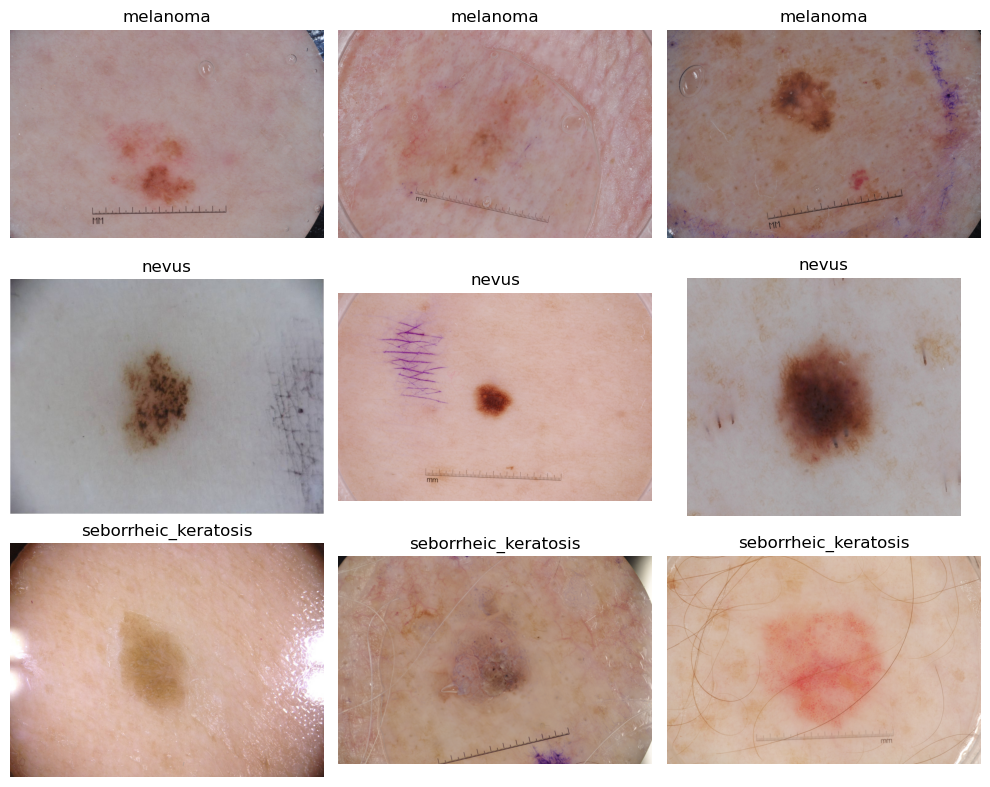

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import os

base_dir = "data/skin-lesions/train"
classes = ["melanoma", "nevus", "seborrheic_keratosis"]

fig, axs = plt.subplots(len(classes), 3, figsize=(10, 8))

for i, cls in enumerate(classes):
    class_dir = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:3]
    
    for j in range(3):
        img_path = os.path.join(class_dir, imgs[j])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(cls)

plt.tight_layout()
plt.show()

Directly above, I plotted example classes from the training set. Then, in order, I plotted example classes from the test set and the validation set, all of which are labeled accordingly.

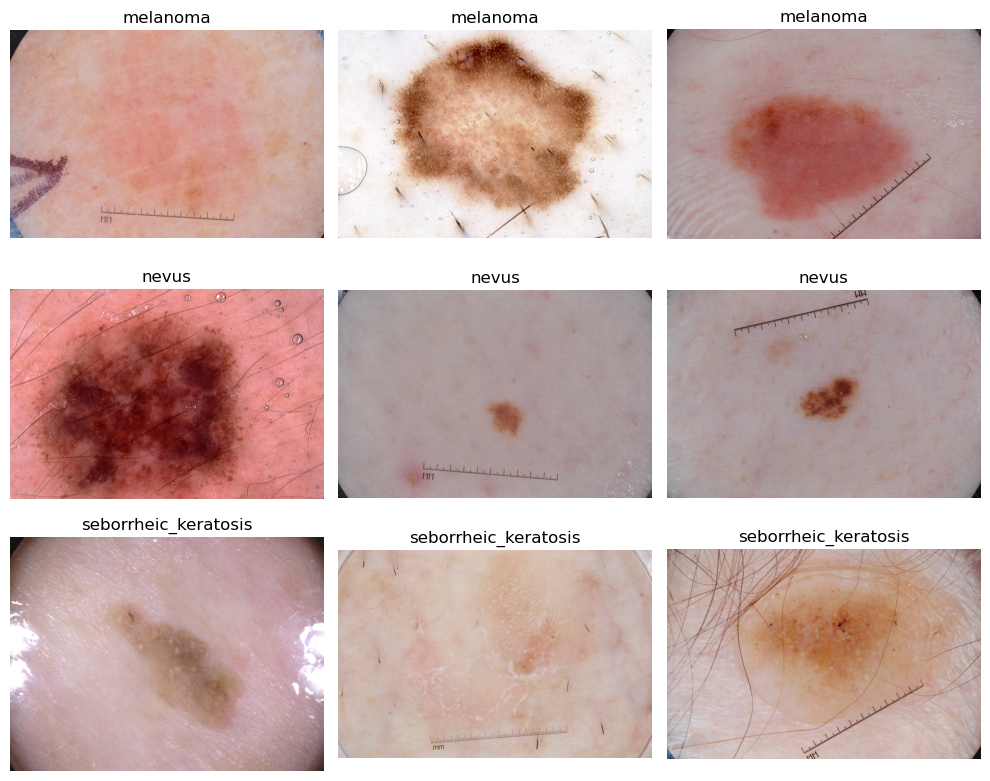

In [6]:
base_dir = "data/skin-lesions/test"
classes = ["melanoma", "nevus", "seborrheic_keratosis"]

fig, axs = plt.subplots(len(classes), 3, figsize=(10, 8))

for i, cls in enumerate(classes):
    class_dir = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:3]
    
    for j in range(3):
        img_path = os.path.join(class_dir, imgs[j])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(cls)

plt.tight_layout()
plt.show()

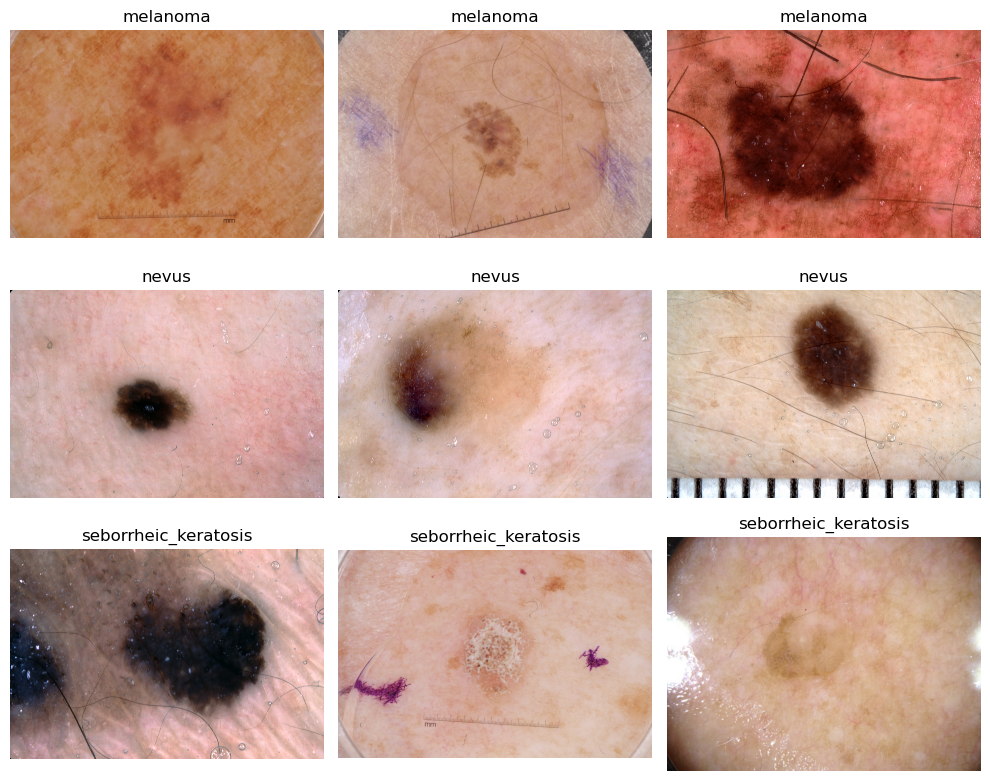

In [7]:
base_dir = "data/skin-lesions/valid"
classes = ["melanoma", "nevus", "seborrheic_keratosis"]

fig, axs = plt.subplots(len(classes), 3, figsize=(10, 8))

for i, cls in enumerate(classes):
    class_dir = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:3]
    
    for j in range(3):
        img_path = os.path.join(class_dir, imgs[j])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(cls)

plt.tight_layout()
plt.show()